# Structure Learning with GES

This notebook demonstrates running GES (Greedy Equivalence Search) on League of Legends match data to learn causal structures.


In [1]:
# Imports
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import config, preprocessing, ges, parameters, queries, visualize

%matplotlib inline
%load_ext autoreload
%autoreload 2

print("Loaded modules successfully!")


Loaded modules successfully!


## 1. Preprocess Data for a Specific Rank

Let's start with Diamond rank as an example.


In [2]:
# Choose rank to analyze
RANK = "Diamond"

# Preprocess data (use small sample for quick demo)
print(f"Preprocessing data for {RANK}...")
data = preprocessing.preprocess_for_rank(RANK, sample_size=5000)

print(f"\nDataset shape: {data.shape}")
print(f"Variables: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()


INFO:src.preprocessing:Preprocessing data for rank: Diamond
INFO:src.preprocessing:Loading match IDs from /home/kano/Documents/bdsproject/notebooks/../data/match_ids.csv


Preprocessing data for Diamond...


INFO:src.preprocessing:Loading match data from /home/kano/Documents/bdsproject/notebooks/../data/matchData.csv
INFO:src.preprocessing:Loaded 5000 matches
INFO:src.preprocessing:Extracting features from team0 perspective
INFO:src.preprocessing:Extracted features for 4882 matches
INFO:src.preprocessing:Assigning rank buckets
INFO:src.preprocessing:Rank distribution:
rank_bucket
Master      1859
Diamond     1011
Platinum     911
Elite        337
Name: count, dtype: int64
INFO:src.preprocessing:Filtered to 1011 matches for rank Diamond
INFO:src.preprocessing:Final dataset: 1011 samples with 13 variables



Dataset shape: (1011, 13)
Variables: ['FB', 'FT', 'Kills10', 'Gold10', 'Herald', 'Kills20', 'Gold20', 'Drakes', 'Soul', 'Baron', 'Inhibs', 'Towers', 'Win']

First few rows:


,FB,FT,Kills10,Gold10,Herald,Kills20,Gold20,Drakes,Soul,Baron,Inhibs,Towers,Win
420,0,0,behind,neutral,1,behind,neutral,1,None,0,<=-1,<=-2,0
543,0,0,even,high,1,even,neutral,0,None,0,0,<=-2,0
951,0,0,behind,neutral,0,behind,neutral,1,None,0,0,-1_to_1,0
957,0,0,even,neutral,1,behind,neutral,0,None,0,<=-1,<=-2,0
963,0,0,behind,low,1,behind,low,1,None,0,<=-1,<=-2,0


## 2. Run GES Structure Learning


In [3]:
# Run GES algorithm
print("Running GES structure learning...")
print("This may take a minute...")

result = ges.fit_ges(data, use_constraints=True)

print(f"\n✓ Structure learning complete!")
print(f"  - Number of variables: {len(result['variables'])}")
print(f"  - Number of edges: {result['n_edges']}")
print(f"\nLearned edges:")
for from_var, to_var, edge_type in result['edges']:
    symbol = "→" if edge_type == "directed" else "—"
    print(f"  {from_var} {symbol} {to_var}")


INFO:src.ges:Running GES structure learning
INFO:src.ges:Encoded 11 variables with 1011 samples
INFO:src.ges:Created forbidden matrix with 43 forbidden edges
INFO:src.ges:Running GES with 11 variables and 1011 samples


Running GES structure learning...
This may take a minute...


INFO:src.ges:GES completed successfully
INFO:src.ges:Adding edges to outcome variable: Win
INFO:src.ges:  Added edge: Towers → Win (MI=0.540)
INFO:src.ges:  Added edge: Kills20 → Win (MI=0.439)
INFO:src.ges:  Added edge: Inhibs → Win (MI=0.421)
INFO:src.ges:Learned structure with 8 edges



✓ Structure learning complete!
  - Number of variables: 11
  - Number of edges: 8

Learned edges:
  Gold10 → Herald
  Kills20 → Gold20
  Kills20 — Towers
  Towers → Gold20
  Baron → Inhibs
  Towers → Win
  Kills20 → Win
  Inhibs → Win


## 3. Visualize the Learned Structure


INFO:src.visualize:Plotting CPDAG: Learned CPDAG - Diamond (8 edges)


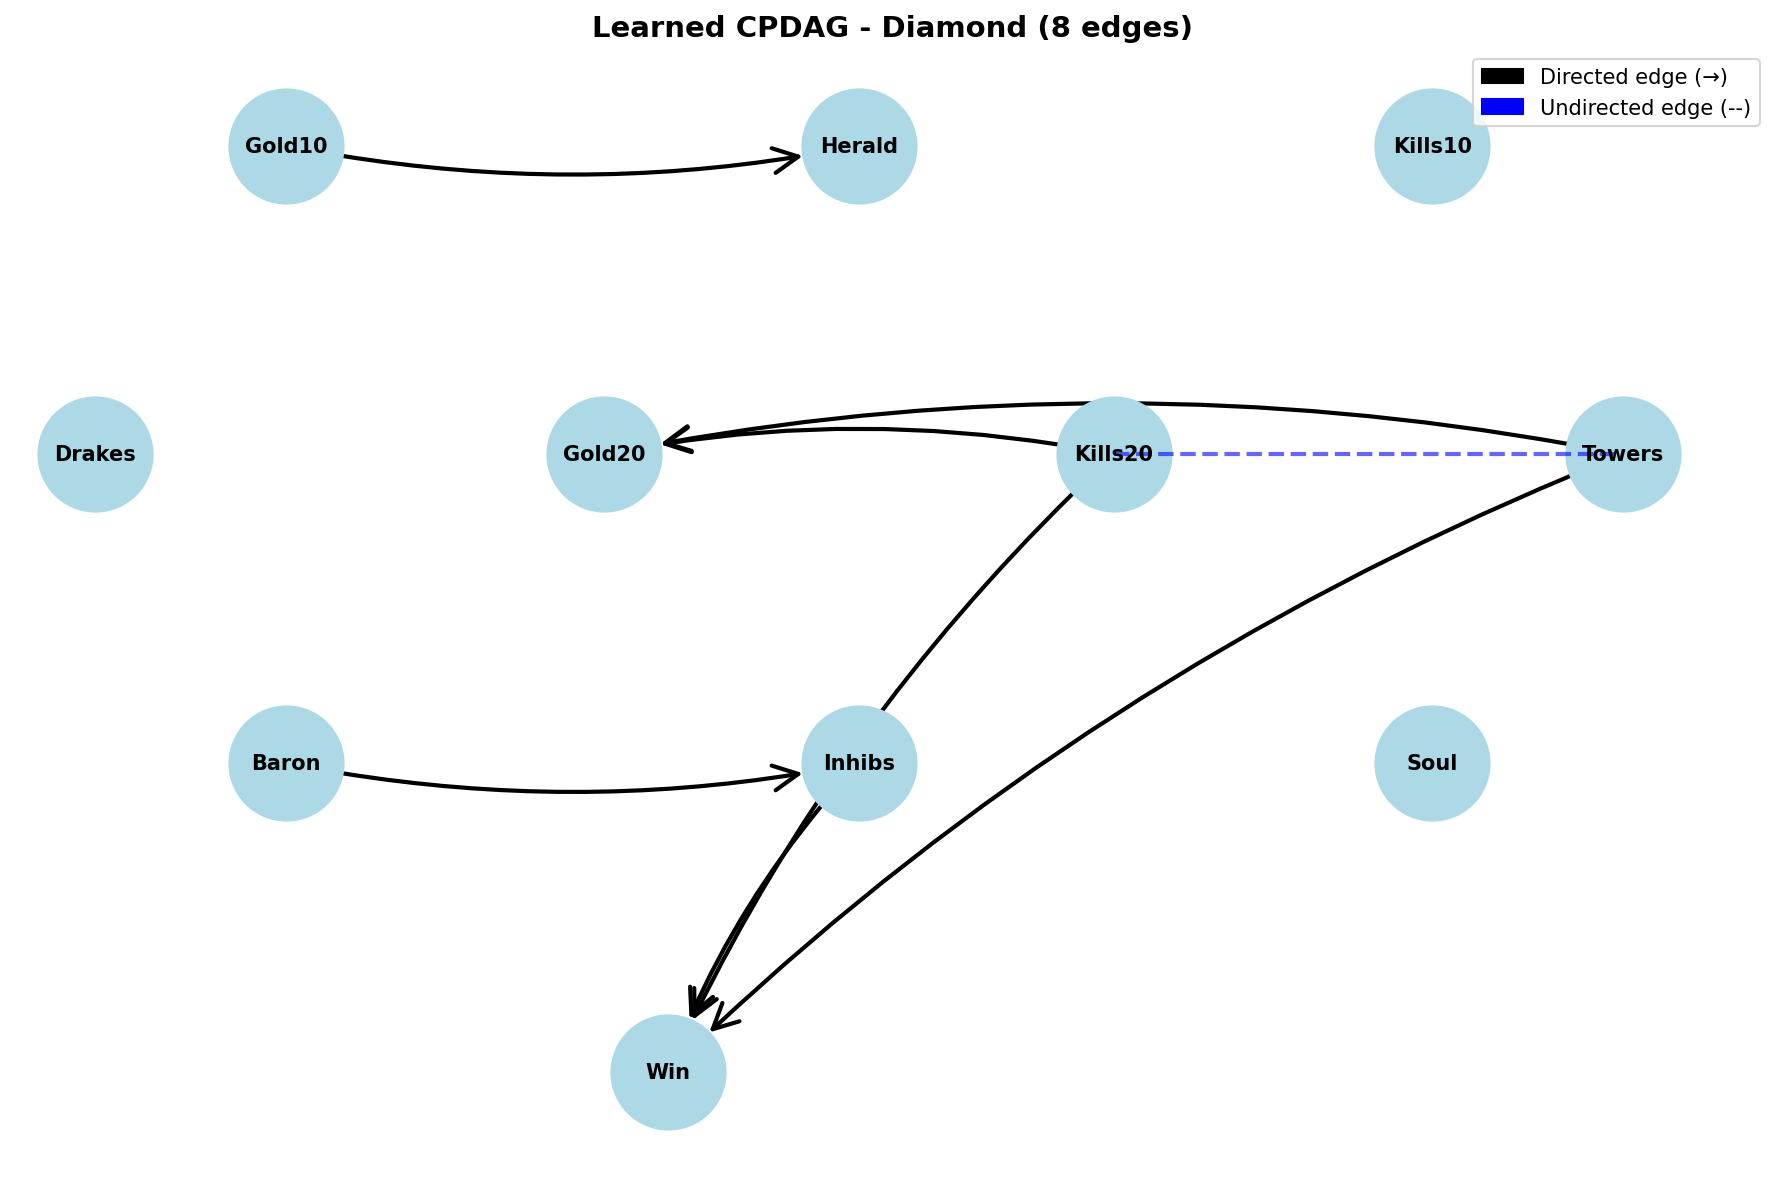

In [4]:
# Visualize the CPDAG
fig = visualize.plot_cpdag(
    result['edges'],
    result['variables'],
    title=f"Learned CPDAG - {RANK} ({result['n_edges']} edges)",
    layout="hierarchical"
)
plt.show()


## 4. Learn Parameters (CPTs)


In [5]:
# Learn CPTs from data
print("Learning conditional probability tables...")

model = parameters.learn_parameters_from_ges(result, data)

print(f"✓ Parameter learning complete!")
print(f"  - Nodes: {len(model.nodes())}")
print(f"  - Edges: {len(model.edges())}")
print(f"  - CPTs: {len(model.get_cpds())}")

# Validate CPTs
validation = parameters.validate_cpts(model)
if validation["valid"]:
    print("  - ✓ CPTs are valid")
else:
    print(f"  - ⚠ Validation warnings: {validation['warnings']}")


INFO:src.ges:Converted CPDAG to DAG with 8 directed edges
INFO:src.parameters:Creating Bayesian Network with 8 edges
INFO:src.parameters:Created BN with 11 nodes and 8 edges
INFO:src.parameters:Fitting CPTs using BayesianEstimator
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Gold10': 'C', 'Herald': 'C', 'Kills20': 'C', 'Gold20': 'C', 'Towers': 'C', 'Baron': 'C', 'Inhibs': 'C', 'Win': 'C', 'Kills10': 'C', 'Drakes': 'C', 'Soul': 'C'}
INFO:src.parameters:CPT fitting completed. Created 8 CPDs for 11 nodes
INFO:src.parameters:Created marginal CPD for isolated node 'Soul' with cardinality 5
INFO:src.parameters:Created marginal CPD for isolated node 'Drakes' with cardinality 5
INFO:src.parameters:Created marginal CPD for isolated node 'Kills10' with cardinality 3


Learning conditional probability tables...
✓ Parameter learning complete!
  - Nodes: 11
  - Edges: 8
  - CPTs: 11
  - ✓ CPTs are valid


## 5. Inspect CPTs


In [6]:
# Show CPT for Win variable (most interesting)
win_cpd = model.get_cpds('Win')
print("CPT for Win variable:")
print(win_cpd)


CPT for Win variable:
+---------+--------------------+-----+---------------------+
| Inhibs  | Inhibs(0)          | ... | Inhibs(>=1)         |
+---------+--------------------+-----+---------------------+
| Kills20 | Kills20(ahead)     | ... | Kills20(even)       |
+---------+--------------------+-----+---------------------+
| Towers  | Towers(-1_to_1)    | ... | Towers(>=2)         |
+---------+--------------------+-----+---------------------+
| Win(0)  | 0.0886426592797784 | ... | 0.09046587215601301 |
+---------+--------------------+-----+---------------------+
| Win(1)  | 0.9113573407202216 | ... | 0.909534127843987   |
+---------+--------------------+-----+---------------------+


## 6. Run Probabilistic Queries


In [7]:
# Run example queries
print("Running example queries...\n")

query_results = queries.run_example_queries(model, RANK)


INFO:src.queries:Running example queries for rank: Diamond


Running example queries...



ERROR:src.queries:Error computing P(Win | {'Soul': 'Infernal', 'Gold20': 'low'}): 'state: Infernal is an unknown for variable: Soul. It must be one of [0, 1, 2, 3, 4]'
ERROR:src.queries:Error computing P(Win | {'Drakes': '3', 'FT': 1, 'Towers': '>=2'}): Node FT not in graph
ERROR:src.queries:Error computing P(Win | {'FB': 1}): Node FB not in graph
ERROR:src.queries:Error computing P(Win | {'Baron': '1', 'Soul': 'Mountain'}): 'state: Mountain is an unknown for variable: Soul. It must be one of [0, 1, 2, 3, 4]'
ERROR:src.queries:Error computing P(Win | {'Herald': '1', 'Kills10': 'ahead'}): 'state: ahead is an unknown for variable: Kills10. It must be one of [0, 1, 2]'
ERROR:src.queries:Error computing P(Win | {'Kills20': 'behind', 'Drakes': '3', 'Herald': '1'}): 'state: 3 is an unknown for variable: Drakes. It must be one of [0, 1, 2, 3, 4]'
ERROR:src.queries:Error computing P(Win | {'Baron': '1', 'Inhibs': '>=1', 'Soul': 'Infernal'}): 'state: Infernal is an unknown for variable: Soul. I


QUERY RESULTS FOR DIAMOND

                                            Query                                            Evidence  P(Win=1)  P(Win=0)
                    High Baron and Gold Advantage                    {'Baron': '1', 'Gold20': 'high'}  0.905767  0.094233
                      Infernal Soul with Low Gold               {'Soul': 'Infernal', 'Gold20': 'low'}       NaN       NaN
Multiple Drakes, First Tower, and Tower Advantage           {'Drakes': '3', 'FT': 1, 'Towers': '>=2'}       NaN       NaN
                                 First Blood Only                                           {'FB': 1}       NaN       NaN
                                   Baron and Soul                  {'Baron': '1', 'Soul': 'Mountain'}       NaN       NaN
                       Herald and Early Kill Lead                 {'Herald': '1', 'Kills10': 'ahead'}       NaN       NaN
            Behind in Kills but Strong Objectives {'Kills20': 'behind', 'Drakes': '3', 'Herald': '1'}       NaN       

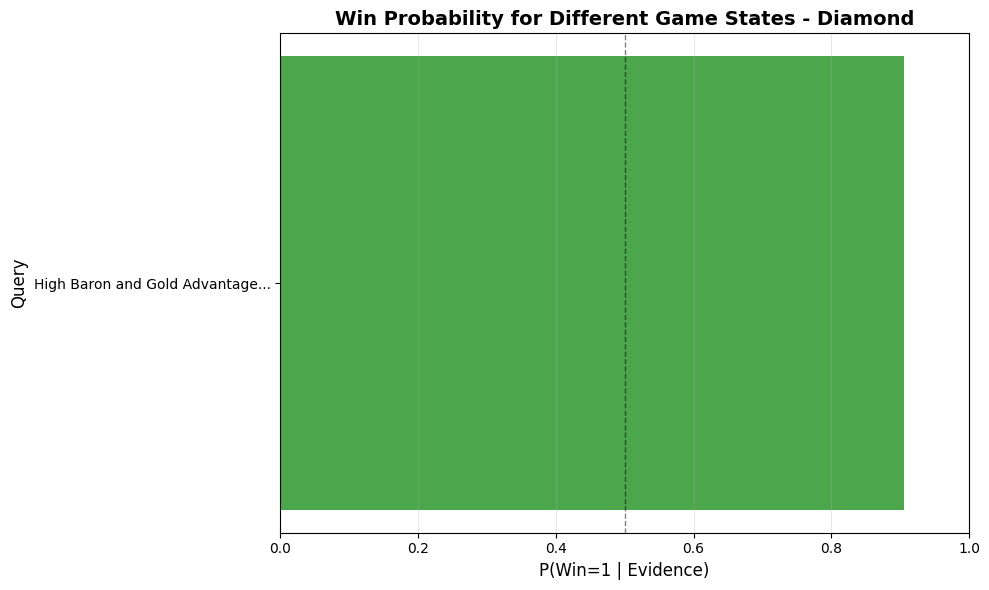

In [8]:
# Visualize query results
fig, ax = plt.subplots(figsize=(10, 6))

query_results['Query_Short'] = query_results['Query'].str[:30] + '...'
colors = ['green' if p > 0.6 else 'orange' if p > 0.4 else 'red' 
          for p in query_results['P(Win=1)']]

ax.barh(query_results['Query_Short'], query_results['P(Win=1)'], color=colors, alpha=0.7)
ax.set_xlabel('P(Win=1 | Evidence)', fontsize=12)
ax.set_ylabel('Query', fontsize=12)
ax.set_title(f'Win Probability for Different Game States - {RANK}', 
             fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Custom Queries


In [9]:
# Ask custom questions
custom_queries = [
    {"name": "First Blood only", "evidence": {"FB": 1}},
    {"name": "First Tower only", "evidence": {"FT": 1}},
    {"name": "FB + FT", "evidence": {"FB": 1, "FT": 1}},
    {"name": "High gold @20", "evidence": {"Gold20": "high"}},
    {"name": "Low gold @20", "evidence": {"Gold20": "low"}},
    {"name": "Baron + High Gold", "evidence": {"Baron": "1", "Gold20": "high"}},
    {"name": "Multiple Drakes", "evidence": {"Drakes": "3"}},
]

custom_results = queries.query_multiple(custom_queries, model)
print("\nCustom Query Results:")
print(custom_results.to_string(index=False))


ERROR:src.queries:Error computing P(Win | {'FB': 1}): Node FB not in graph
ERROR:src.queries:Error computing P(Win | {'FT': 1}): Node FT not in graph
ERROR:src.queries:Error computing P(Win | {'FB': 1, 'FT': 1}): Node FB not in graph
ERROR:src.queries:Error computing P(Win | {'Drakes': '3'}): 'state: 3 is an unknown for variable: Drakes. It must be one of [0, 1, 2, 3, 4]'



Custom Query Results:
            Query                         Evidence  P(Win=1)  P(Win=0)
 First Blood only                        {'FB': 1}       NaN       NaN
 First Tower only                        {'FT': 1}       NaN       NaN
          FB + FT               {'FB': 1, 'FT': 1}       NaN       NaN
    High gold @20               {'Gold20': 'high'}  0.791056  0.208944
     Low gold @20                {'Gold20': 'low'}  0.035015  0.964985
Baron + High Gold {'Baron': '1', 'Gold20': 'high'}  0.905767  0.094233
  Multiple Drakes                  {'Drakes': '3'}       NaN       NaN


## 8. Analyze Variable Influence on Win

Which variables have the strongest impact on winning?


In [10]:
# Analyze variable influence
influence = queries.analyze_variable_influence("Win", model, data)

print("\nTop 10 Most Influential Variable States:")
print(influence.head(10).to_string(index=False))

print("\nBottom 10 (Most Negative Impact):")
print(influence.tail(10).to_string(index=False))



Top 10 Most Influential Variable States:
Variable   Value  P(Target=1|Var)  Influence     Lift
 Kills20   ahead         0.793818   0.375934 1.899612
  Gold20    high         0.791056   0.373171 1.893002
  Towers     >=2         0.786587   0.368703 1.882309
  Inhibs     >=1         0.529989   0.112105 1.268268
  Inhibs       0         0.499363   0.081479 1.194979
   Baron      2+         0.492256   0.074372 1.177973
   Baron       1         0.484065   0.066181 1.158371
  Towers -1_to_1         0.449531   0.031647 1.075732
  Herald       0         0.417884   0.000000 1.000000
  Herald       1         0.417884   0.000000 1.000000

Bottom 10 (Most Negative Impact):
Variable   Value  P(Target=1|Var)  Influence     Lift
  Gold10    high         0.417884   0.000000 1.000000
  Gold10     low         0.417884   0.000000 1.000000
  Gold10 neutral         0.417884   0.000000 1.000000
 Kills20    even         0.413247  -0.004637 0.988903
   Baron       0         0.389580  -0.028305 0.932267
  Gol

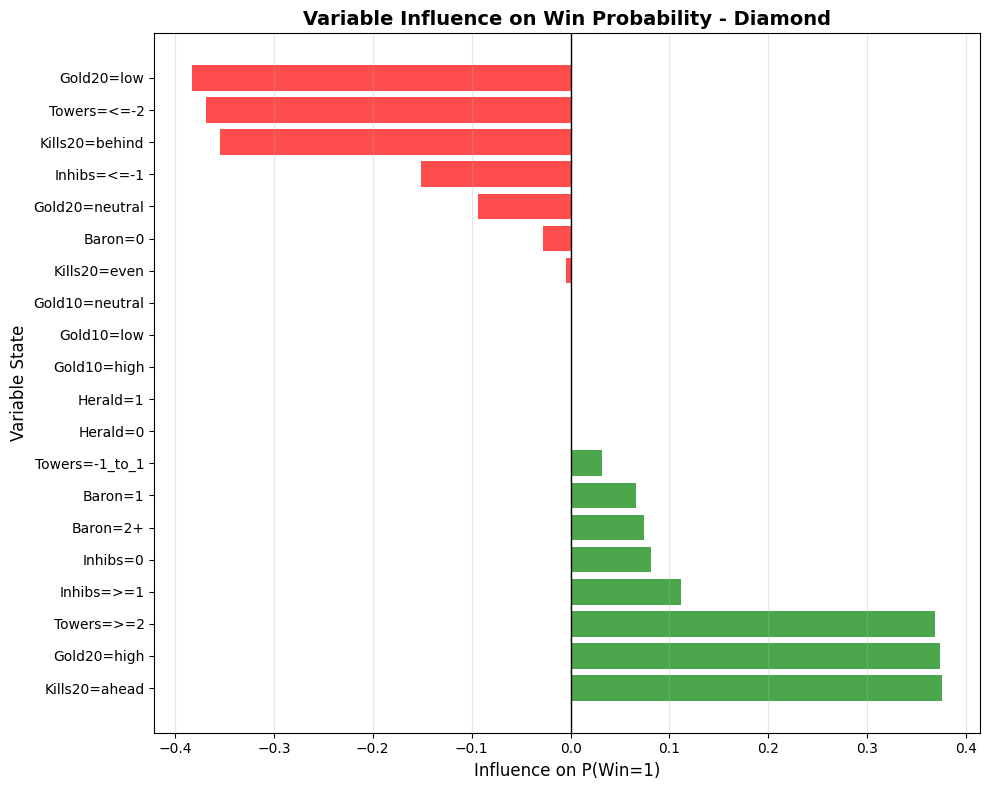

In [11]:
# Visualize influence
top_influences = pd.concat([influence.head(10), influence.tail(10)])

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_influences['Influence']]
y_labels = [f"{row['Variable']}={row['Value']}" for _, row in top_influences.iterrows()]

ax.barh(y_labels, top_influences['Influence'], color=colors, alpha=0.7)
ax.set_xlabel('Influence on P(Win=1)', fontsize=12)
ax.set_ylabel('Variable State', fontsize=12)
ax.set_title(f'Variable Influence on Win Probability - {RANK}', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



Use the CLI for full pipeline
```bash
python -m src.cli full --ranks Diamond Platinum Master Elite
```
